<div align=center>
		
<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
 <br/>
    <br/>
    <br/>
<font color=#FF7500>
Sharif University of Technology - Departmenet of Computer Engineering
</font>
<p></p>
<font color=blue>
Artifical Intelligence - Dr. Mohammad Hossein Rohban
</font>
<br/>
<br/>
Fall 2021

</div>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
Practical Assignment 4 Pytorch Classification
            	<br/>
			</font>
    <br/>
    <br/>
<font size=4>
                <br/><b>
              Cheating is Strongly Prohibited
                </b><br/><br/>
                <font color=red>
Please run all the cells.
     </font>
</font>
                <br/>
    </div>

# Personal Data

In [ ]:
# Set your student number
student_number = 98101339
Name = 'Sayeh'
Last_Name = 'Jarollahi'

# Rules
- You **are** allowed to add or remove cells. 
- By running the cell below, you can see if your jupyter file is accepted or not. This cell will also **generate a python file which you'll have to upload to Quera** (as well as your jupyter file). The python file will later be validated and if the code in both files doesn't match, **your Practical Assignment won't be graded**.

In [113]:
# remember to save your jupyter file before running this script
from Helper_codes.validator import *

python_code = extract_python("./Q2.ipynb")
with open(f'python_code_Q2_{student_number}.py', 'w') as file:
    file.write(python_code)

ImportError: ignored

# PyTorch & MNIST Classification (50 points+5 Extra)

<font size=4>
Author: Arman Zarei
			<br/>
                <font color=red>
Please run all the cells.
     </font>
</font>
                <br/>
    </div>

In this assignment, you are going to learn the fundamentals of PyTorch and implement a classifier network for MNIST dataset. You can read about more details of PyTorch components from [this link](https://pytorch.org/tutorials).

### Setup

In [111]:
from google.colab import drive 
drive._mount('/content/drive')
import sys 
 
address = 'MPQ4/Practical' 
sys.path.append(f'content/drive/MyDrive/{address}') 
 
% cd /content/drive/MyDrive/$address

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MPQ4/Practical


In [112]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import os
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from Helper_codes.ae_helper import init_mnist_subset_directories

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### Loading dataset

In [ ]:
mnist_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Autograd

Autograd is PyTorch's automatic differentiation engine that powers neural network training. In essence it helps us to calculate derivatives and updating parameters. To read more about Autograd and Computational Graph visit [this link](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)

Let us define two parameters: $p_1$ and $p_2$. 

In [ ]:
p1 = torch.tensor([3.], requires_grad=True)
p2 = torch.tensor([7.], requires_grad=True)

NameError: ignored

Now define a variable $L$ as below:

$L = 3 \times p_1^3 - 7 \times p_2^2 + sin(p1) \times p_2^2$

In [ ]:
L = 3 * torch.pow(p1, 3) - 7 * torch.pow(p2, 2) + torch.sin(p1)*torch.pow(p2, 2)
L
# Place your code here (2.5 Points)
# Hint: You can use torch.sin for calculation of sin(p1)

tensor([-255.0851], grad_fn=<AddBackward0>)

Now you have to calculate the gradient of $p_1$ and $p_2$ with respect to $L$. First do it by hand and write the mathematical expression in the below cell both for $p_1$ and $p_2$. Then evaluate them at $3$ and $7$ (acording to the initialization)

Place your expressions here **(2.5 Points)**


$\frac{dL}{dp_1} = 9 \times p_1^2+p_2^2 \times cos(p1)$ 

$\frac{dL}{dp_2} = -14\times p_2 +2\times p_2\times sin(p_1)$

$\frac{dL}{dp_1}(3, 7) = 32.4904$

$\frac{dL}{dp_2}(3, 7) = -96.0243$

In [ ]:
d_p1 = torch.add(torch.mul(9, torch.pow(p1, 2)), torch.mul(torch.cos(p1),torch.pow(p2, 2)))
print(d_p1)
d_p2 = -14 * p2 + 2*p2*torch.sin(p1)
print(d_p2)

tensor([32.4904], grad_fn=<AddBackward0>)
tensor([-96.0243], grad_fn=<AddBackward0>)


Now let's calculate this using pytorch. The below code will construct the 

---

computational graph and stores the gradient of each variable inside of it.

In [ ]:
L.backward()

Check whether the result of your calculations is the same with the autograd's output.

In [ ]:
print(f"P_1 grad: {p1.grad.item()}\nP_2 grad: {p2.grad.item()}")

P_1 grad: 32.4903678894043
P_2 grad: -96.02432250976562


## Transform 

Data does not always come in its final processed form that is required for training machine learning algorithms. We use transforms to perform some manipulation of the data and make it suitable for training. For more details, you can read [this link](https://pytorch.org/vision/stable/transforms.html)

There are many transformations that are already implemented inside pytorch that you can use. Here we are going to implement some transformation from scratch using PyTorch's framework.

#### Random Horizontal Flip Transformation

Define a transformation that flips the image (horizontally) with probability of $p$. In order to implement a simple transformation class, you need to have two methods: `__init__` and `__call__` (which receives the image)

In [ ]:
class RandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p 
     
    def __call__(self, x):
        if torch.rand(1) > self.p:
            return x
        return torch.flip(x, [len(x.shape) - 1])


#### Random Color Swap

Now that you have learned how to implement a transformation class, let's build another one. Define a transformation which swaps the colors (in the gray scale image) with probability of $p$. For example, if the given image had a white colored number with a black background, it should output an image with black colored number and a white background.

**Hint:** for a given input $x$, you can concider the swapped color version of it as $x_{new} = m - x$ where $m$ is the maximum value in image $x$

In [ ]:
class RandomColorSwap(object):

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, x):
        if torch.rand(1) > self.p:
            return x
        max_val = torch.max(x).item()
        return torch.mul(torch.sub(x, max_val), -1)


### Evaluation of transformations

Now, let's apply these transformations on some images of our dataset. You can stack different transformation using `Compose`

In [ ]:
trans = transforms.Compose([
  RandomHorizontalFlip(p=0.7),
  RandomColorSwap()
])

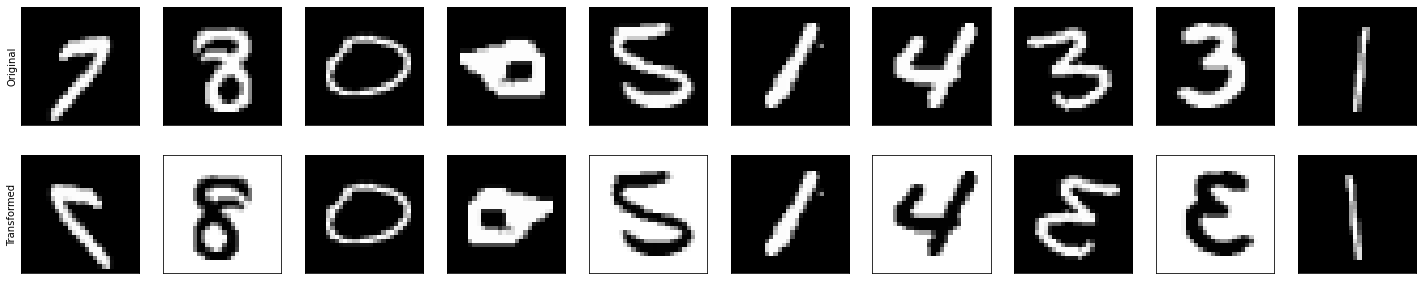

In [ ]:
num_imgs = 10
fig, axs = plt.subplots(2, num_imgs, figsize=(25, 5))
for i, idx in enumerate(torch.randint(0, len(mnist_dataset), [num_imgs])):
    x, y = mnist_dataset[idx]
    axs[0, i].imshow(x[0], cmap='gray')
    axs[1, i].imshow(trans(x)[0], cmap='gray')
    for k in range(2):
        axs[k, i].set_yticks([])
        axs[k, i].set_xticks([])

axs[0, 0].set_ylabel("Original")
axs[1, 0].set_ylabel("Transformed");

What we expect to see is that, some of them are fliped horizontally, some swapped in color, and some both.

## Dataset

In this section, we are going to implement a dataset class. Inside `torchvision.datasets` there are many Datasets that are already implemented and ready to use. But, in many situations it's necessary to implement one by your self.

Run the below cell to initialize our dataset

In [ ]:
dataset_path = "new_mnist"
init_mnist_subset_directories(mnist_dataset, dataset_path)

If you take a look at `new_mnist` directory which is created in the directory you are working in, you see that it contains 10 folders with names from `0` to `9` indicating the label of the images inside it. Inside each, some files with name `data_{number}.pth` exist. Each `.pth` file is an image.

Now you have to implement a Dataset on top of these files.
The methods that you should implement in a Dataset (as you can see in the code) is as described below:
- `__init__`: In our example assume that it only accepts `root_dir` and `transform` as it's parameters (You should apply the transformations before outputing the data)
- `__len__`: Should return the number of data in your dataset
- `__getitem__`: which receives an index, should return the data at the given index (which is a tuple here, containing image and the corresponding label) 

In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.data = []
        self.transform = transform 
        for dir_name in os.listdir(root_dir):
            for file_name in os.listdir(os.path.join(root_dir, dir_name)):
                model = torch.load(os.path.join(root_dir, dir_name, file_name))
                self.data.append((transform(model), dir_name))

        # Place your code here (4 Points)
        ## Hint: Use os.listdir(some_path) to get the list of files
    

    def __len__(self):
        return len(self.data)
        

    def __getitem__(self, idx):
        return self.data[idx]

After you defined your dataset, let's use it.

In [ ]:
my_dataset = MNISTDataset(root_dir=dataset_path, transform=RandomColorSwap())
len(my_dataset)

5000

Visualize 10 samples (randomely) from your dataset with their labels

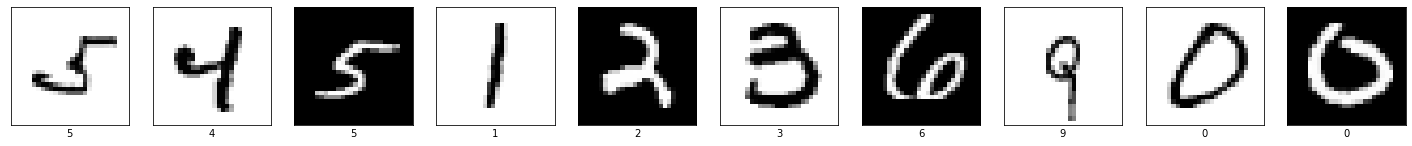

In [ ]:
# Place your code here (2 Points)
fig, axs = plt.subplots(1, 10, figsize=(25, 5))
for i, idx in enumerate(torch.randint(0, len(my_dataset), [10])):
    x, y = my_dataset[idx]
    axs[i].imshow(x[0], cmap='gray')
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set(xlabel=y)


## MNIST Classification

### Model
Define your model (Based on what you have learned in the workshop). I highly encourage you to try different models with different layers in order to achieve a better accuracy

**Notice:** You cannot use convolution layers in your model 

In [87]:
# Place your code here (5 points)
hidden_size = 500
output_dim = 10
images_dim = 784
class DigitRecognizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
                      nn.Linear(images_dim, hidden_size),
                      nn.ReLU(),
                      nn.Linear(hidden_size, output_dim))
                
        
    def forward(self, x: torch.Tensor):
        x = self.layers(x)
        return x


In [100]:
model = DigitRecognizer().to(device)
model

DigitRecognizer(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=10, bias=True)
  )
)

### Dataset and Dataloader

Prepare datasets and dataloader for train/test. We use MNIST dataset that is already implemented inside `torchvision.datasets`.

 You need to split the `mnist_dataset` into `train_dataset` and `val_dataset`. 
 
 You can also define more transformations that you think it would help the training process **(Optional)**.

In [101]:
transform_compose = transforms.Compose([
    transforms.ToTensor(),
    # Place your code here
])

mnist_dataset = datasets.MNIST(root='dataset', train=True, download=True, transform=transform_compose)
train_size = int(0.9 * len(mnist_dataset))
val_size = len(mnist_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(mnist_dataset, (train_size, val_size))
test_dataset = datasets.MNIST(root='dataset', train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

### Criterion and Optimizer

you have to tune the `learning_rate` yourself (Based on your training process)

In [102]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Train your model

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). You also need to store train/validation loss at each epoch in order to visualize them the after training is done.

In [78]:
def train_epoch():
    train_loss = 0
    with tqdm.tqdm(enumerate(train_loader), total=len(train_loader)) as pbar:
        epoch_loss = 0
        epoch_true = 0
        epoch_all = 0
        model.train()
        for i, (x, y) in pbar:
            x = x.reshape(-1, 784).to(device)
            y = y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            epoch_loss += float(loss)
            predictions = outputs.argmax(-1)
            epoch_all += len(predictions)
            epoch_true += (predictions == y).sum()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += (train_loader.batch_size * loss.item())
        return epoch_true, epoch_all, train_loss



In [79]:
def eval_epoch(model, criterion, dataloader):
    epoch_loss = 0
    epoch_true = 0
    epoch_all = 0
    val_loss = 0
    i = 0
    loss_images, loss_correct_label, loss_predicted = [],[],[]
    model.eval()
    with torch.no_grad(), tqdm.tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (x, y) in pbar:
            x = x.reshape(-1, 784).to(device)
            y = y.to(device)
            p = model(x)

            loss = criterion(p, y)
            epoch_loss += float(loss)

            predictions = p.argmax(-1)
            epoch_all += len(predictions)
            epoch_true += (predictions == y).sum()

            loss_images.extend(list(x[predictions != y]))
            loss_correct_label.extend(list(y[predictions != y]))
            loss_predicted.extend(list(predictions[predictions !=y]))
            val_loss += float(loss.item()*dataloader.batch_size)
    return val_loss, epoch_true, epoch_all, loss_images, loss_correct_label, loss_predicted

In [103]:
import tqdm
num_epochs= 35

train_loss_arr, val_loss_arr = [], []
for epoch in range(num_epochs):
    train_epoch_true, train_epoch_all, train_loss = train_epoch()
    val_loss, epoch_true, epoch_all, _, _, _ = eval_epoch(model, criterion, val_loader)
    # Place your code here (4 points)
    ## Hint: Loop throught val_loader, get images with their labels and evaluate the model
    ## Hint 2: To update val_loss inside the loop use "val_loss += batch_loss * batch_size""
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_loss_arr.append(train_loss)
    val_loss_arr.append(val_loss)
    
    print(f"[Epoch {epoch}]\t"
        f"Train Loss: {train_loss:.4f}\t"
        f"Validation Loss: {val_loss:.4f}")


100%|██████████| 188/188 [00:01<00:00, 182.97it/s]


[Epoch 0]	Train Loss: 0.5435	Validation Loss: 0.2935


100%|██████████| 188/188 [00:01<00:00, 183.77it/s]


[Epoch 1]	Train Loss: 0.2618	Validation Loss: 0.2299


100%|██████████| 188/188 [00:01<00:00, 182.03it/s]


[Epoch 2]	Train Loss: 0.2079	Validation Loss: 0.1941


100%|██████████| 188/188 [00:01<00:00, 182.92it/s]


[Epoch 3]	Train Loss: 0.1721	Validation Loss: 0.1655


100%|██████████| 188/188 [00:01<00:00, 170.50it/s]


[Epoch 4]	Train Loss: 0.1462	Validation Loss: 0.1434


100%|██████████| 188/188 [00:01<00:00, 181.09it/s]


[Epoch 5]	Train Loss: 0.1256	Validation Loss: 0.1291


100%|██████████| 188/188 [00:01<00:00, 182.44it/s]


[Epoch 6]	Train Loss: 0.1098	Validation Loss: 0.1157


100%|██████████| 188/188 [00:01<00:00, 184.23it/s]


[Epoch 7]	Train Loss: 0.0970	Validation Loss: 0.1079


100%|██████████| 188/188 [00:01<00:00, 185.35it/s]


[Epoch 8]	Train Loss: 0.0858	Validation Loss: 0.1000


100%|██████████| 188/188 [00:01<00:00, 178.41it/s]


[Epoch 9]	Train Loss: 0.0767	Validation Loss: 0.0926


100%|██████████| 188/188 [00:01<00:00, 184.65it/s]


[Epoch 10]	Train Loss: 0.0685	Validation Loss: 0.0882


100%|██████████| 188/188 [00:01<00:00, 179.61it/s]


[Epoch 11]	Train Loss: 0.0618	Validation Loss: 0.0838


100%|██████████| 188/188 [00:01<00:00, 181.81it/s]


[Epoch 12]	Train Loss: 0.0557	Validation Loss: 0.0802


100%|██████████| 188/188 [00:01<00:00, 183.01it/s]


[Epoch 13]	Train Loss: 0.0506	Validation Loss: 0.0765


100%|██████████| 188/188 [00:01<00:00, 178.68it/s]


[Epoch 14]	Train Loss: 0.0455	Validation Loss: 0.0730


100%|██████████| 188/188 [00:01<00:00, 181.23it/s]


[Epoch 15]	Train Loss: 0.0409	Validation Loss: 0.0729


100%|██████████| 188/188 [00:01<00:00, 185.04it/s]


[Epoch 16]	Train Loss: 0.0372	Validation Loss: 0.0719


100%|██████████| 188/188 [00:01<00:00, 180.97it/s]


[Epoch 17]	Train Loss: 0.0335	Validation Loss: 0.0686


100%|██████████| 188/188 [00:01<00:00, 184.72it/s]


[Epoch 18]	Train Loss: 0.0306	Validation Loss: 0.0644


100%|██████████| 188/188 [00:01<00:00, 177.73it/s]


[Epoch 19]	Train Loss: 0.0273	Validation Loss: 0.0644


100%|██████████| 188/188 [00:01<00:00, 184.76it/s]


[Epoch 20]	Train Loss: 0.0248	Validation Loss: 0.0659


100%|██████████| 188/188 [00:01<00:00, 186.97it/s]


[Epoch 21]	Train Loss: 0.0224	Validation Loss: 0.0623


100%|██████████| 188/188 [00:00<00:00, 188.23it/s]


[Epoch 22]	Train Loss: 0.0201	Validation Loss: 0.0632


100%|██████████| 188/188 [00:01<00:00, 186.20it/s]


[Epoch 23]	Train Loss: 0.0181	Validation Loss: 0.0605


100%|██████████| 188/188 [00:01<00:00, 184.38it/s]


[Epoch 24]	Train Loss: 0.0164	Validation Loss: 0.0597


100%|██████████| 188/188 [00:01<00:00, 187.41it/s]


[Epoch 25]	Train Loss: 0.0146	Validation Loss: 0.0631


100%|██████████| 188/188 [00:00<00:00, 188.38it/s]


[Epoch 26]	Train Loss: 0.0131	Validation Loss: 0.0612


100%|██████████| 188/188 [00:01<00:00, 181.48it/s]


[Epoch 27]	Train Loss: 0.0117	Validation Loss: 0.0588


100%|██████████| 188/188 [00:01<00:00, 183.74it/s]


[Epoch 28]	Train Loss: 0.0105	Validation Loss: 0.0619


100%|██████████| 188/188 [00:01<00:00, 187.57it/s]


[Epoch 29]	Train Loss: 0.0093	Validation Loss: 0.0599


100%|██████████| 188/188 [00:01<00:00, 175.14it/s]


[Epoch 30]	Train Loss: 0.0083	Validation Loss: 0.0610


100%|██████████| 188/188 [00:01<00:00, 183.23it/s]


[Epoch 31]	Train Loss: 0.0073	Validation Loss: 0.0599


100%|██████████| 188/188 [00:01<00:00, 185.38it/s]


[Epoch 32]	Train Loss: 0.0067	Validation Loss: 0.0604


100%|██████████| 188/188 [00:01<00:00, 181.39it/s]


[Epoch 33]	Train Loss: 0.0057	Validation Loss: 0.0595


100%|██████████| 188/188 [00:01<00:00, 181.21it/s]

[Epoch 34]	Train Loss: 0.0052	Validation Loss: 0.0596


#### Plot train/validation loss

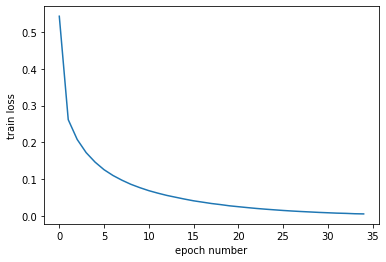

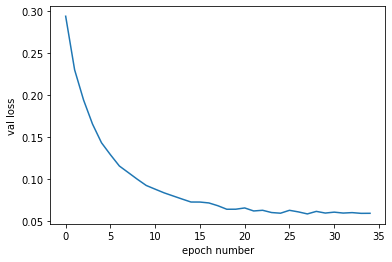

In [104]:
plt.plot(range(len(train_loss_arr)), train_loss_arr)
plt.xlabel('epoch number')
plt.ylabel('train loss')
plt.show()
plt.plot(range(len(val_loss_arr)), val_loss_arr)
plt.xlabel('epoch number')
plt.ylabel('val loss')
plt.show()

### Evaluation

Evaluate your model on test set. you have to report both loss and accuracy.

In order to get the full score of this section, you need to achieve an accuracy above $95\%$ and to get the extra points, your accuracy should be above $98\%$ 

**Notice:** You should use test set only for evaluation of your model.

In [109]:
val_loss, epoch_true, epoch_all, loss_images, loss_correct_label, loss_predicted = eval_epoch(model, criterion, test_loader)
print('\n accuracy percentage :',float(epoch_true*100/epoch_all)  )

100%|██████████| 313/313 [00:01<00:00, 189.44it/s]

tensor(9801, device='cuda:0') 10000

 accuracy percentage : 98.00999450683594


### Visualization of wrong prediction

Visualize $8$ samples (along with original label and model's prediction) from test set which are labeled wrong by your model

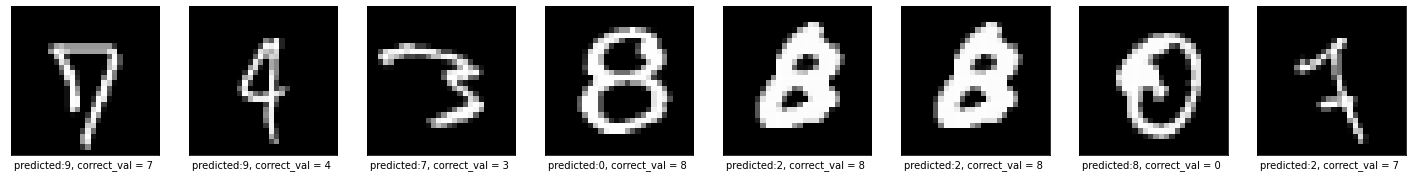

In [106]:
fig, axs = plt.subplots(1, 8, figsize=(25, 5))
for i, idx in enumerate(torch.randint(0, len(loss_images), [8])):
    image = loss_images[idx].reshape((28,28))
    predict = loss_predicted[idx]
    correct = loss_correct_label[idx]
    axs[i].imshow(image.cpu(), cmap='gray')
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set(xlabel=f'predicted:{predict}, correct_val = {correct} ')